In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
class Value:
    def __init__(self, data, __children={}, _op="", label=""):
        self.data = data
        self.grad = 0
        self._prev = set(__children)
        self._op = _op
        self._backward = lambda: None
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    def __neg__(self):
        return self * -1
    def __sub__(self, other):
        return self + (-other)
    def __rmul__(self, other):
        return self * other
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out = Value(self.data * other.data, (self, other), "*")
        out._backward = _backward
        return out
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/floa powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self * other**-1
    def tanh(self):
        def _backward():
            self.grad += (1 - t**2) * out.grad
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')
        out._backward = _backward
        return out
    def exp(self):
        def _backward():
            self.grad += out.data * out.grad
        n = self.data
        out = Value(math.exp(n), (self, ), 'exp')
        out._backward = _backward
        return out
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if(v not in visited):
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

In [34]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [35]:
from graphviz import Digraph

def trace(root):
    # build a set of all the nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if(v not in nodes):
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(v=root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if(n._op):
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [36]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b; n.label='n'

o = n.tanh(); o.label = 'o'
o.backward()

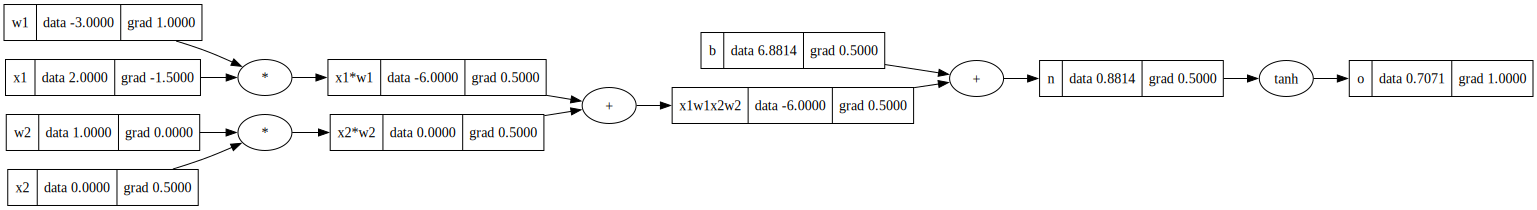

In [37]:
draw_dot(o)

In [38]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b; n.label='n'

e = (2*n).exp()
o = (e - 1) / (e + 1)
o.backward()

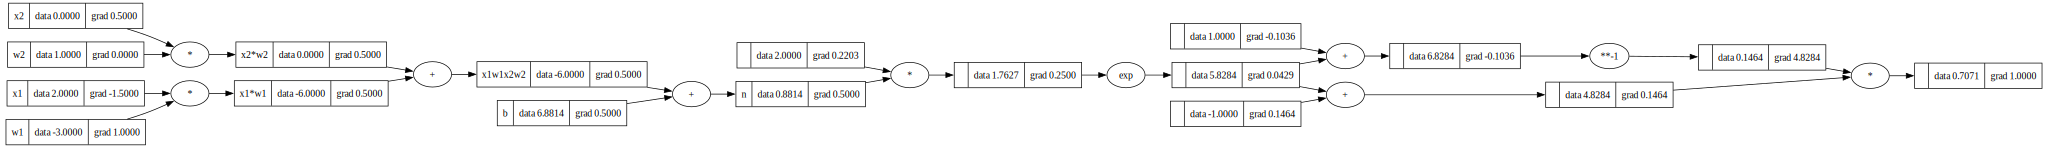

In [32]:
draw_dot(o)